<a href="https://colab.research.google.com/github/ethan-yoo/2022_AIFFEL/blob/main/E10_ShallowFocus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E10. 인물사진 구현하기 Shallow Focus**

In [ ]:
# ! pip install pixellib

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from glob import glob
from os.path import join
import tarfile

print('Done!')

Done!


## **01. 데이터 가져오기**

In [3]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


(1440, 1080, 3)


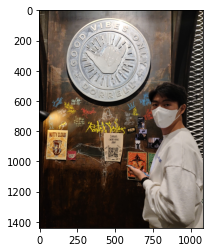

In [4]:
img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/man.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## **02. Human Segmentation Model 생성**

### **02-1. 모델 가져오기**

In [5]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/mydrive/MyDrive/AIFFEL/E10/model'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/mydrive/MyDrive/AIFFEL/E10/model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f274475b710>)

### **02-2. 모델 생성하기**

In [6]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

print('Done!')

Done!


### **02-3. 모델에 이미지 입력하기**

In [7]:
# pip install Pillow==9.0.0

In [8]:
segvalues, output = model.segmentAsPascalvoc(img_path)

> PASCALVOC: http://host.robots.ox.ac.uk/pascal/VOC/

### **라벨 확인**

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [42]:
LABEL_NAMES[10], LABEL_NAMES[8], LABEL_NAMES[12]

('cow', 'cat', 'dog')

### **출력값 확인**

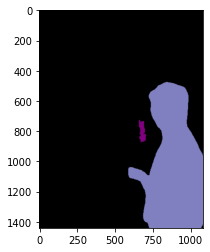

In [10]:
plt.imshow(output)
plt.show()

In [11]:
segvalues

{'class_ids': array([ 0,  5, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [12]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


In [13]:
# PixelLib에서 그대로 가져온 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [14]:
# 사람을 나타내는 색상
colormap[15]

array([192, 128, 128])

In [15]:
# BGR2RGB
seg_color = (128,128,192)

### **02-4. 마스크 생성**

(1440, 1080)


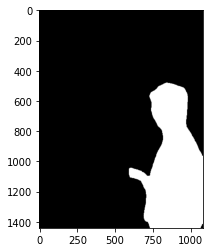

In [16]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

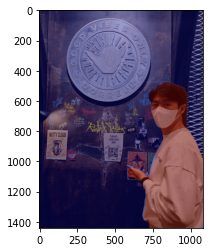

In [17]:
# 원본과 겹쳐보기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

원본 이미지의 크기: (1080, 1440)
변형 마스크의 크기: (1440, 1080)


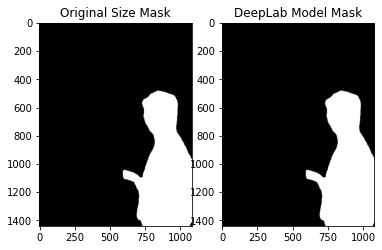

In [18]:
# 원본 사이즈 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'원본 이미지의 크기: {img_orig.shape[:2][::-1]}\n변형 마스크의 크기: {img_mask.shape}')
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## **03. 블러 처리하기**

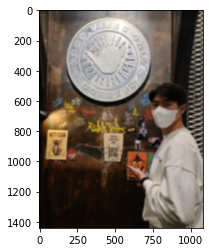

In [19]:
# (13,13)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### **03-1. 배경 추출**

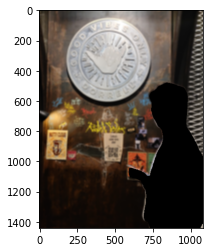

In [20]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### **03-2. 배경과 원본 합성**

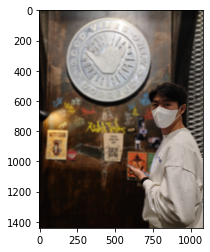

In [21]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## **04. Cat Segmentation**

(702, 563, 3)


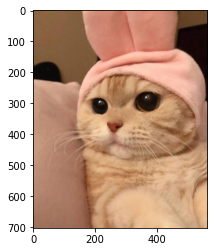

In [22]:
cat_img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/cat.jpeg'
img_orig = cv2.imread(cat_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# 편의상 앞의 과정을 함수로 만들어 사용

def segmentation_modeling(model, img_path, subject_num):
    
    # 모델 생성
    model.load_pascalvoc_model(model_file)
    
    # 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # PixelLib에서 그대로 가져온 코드
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    colormap[:20]
    
    # 타겟 컬러맵
    colormap[subject_num]
    
    # BGR2RGB
    seg_color = (colormap[8][2], colormap[8][1], colormap[8][0])
    
    # 마스크 생성
    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
    print(seg_map.shape)
    plt.imshow(seg_map, cmap='gray')
    plt.show()
    
    # 원본과 겹쳐보기
    img_show = img_orig.copy()
    plt.show()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 블러처리
    # (13,13)은 blurring kernel size를 뜻합니다
    img_orig_blur = cv2.blur(img_orig, (10,10))  
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 배경추출
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 배경에 원본 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    

print('Done!')

Done!


(702, 563)


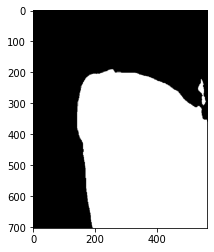

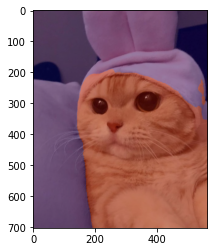

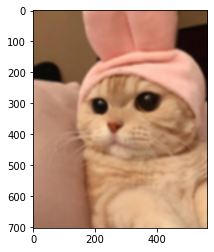

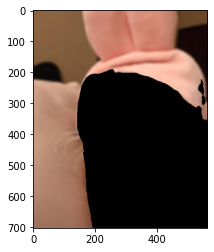

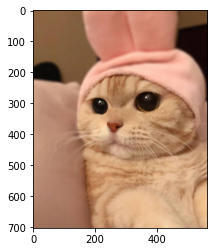

In [24]:
cat_model = semantic_segmentation()
segmentation_modeling(cat_model, cat_img_path, 8) # cat=8

## **05. Cow Segmentation**

(485, 800, 3)


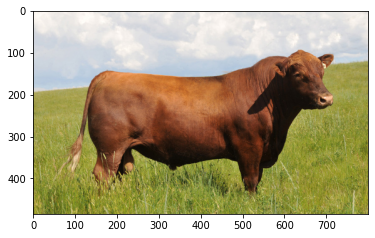

In [26]:
cow_img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/cow.jpeg'
img_orig = cv2.imread(cow_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(485, 800)


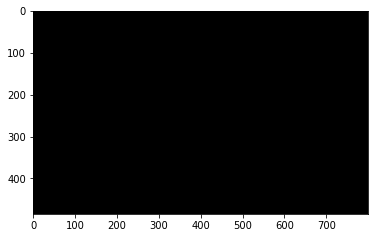

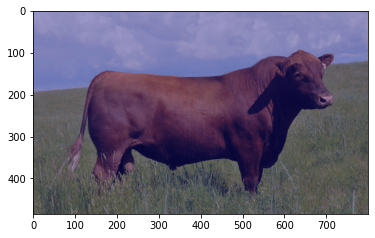

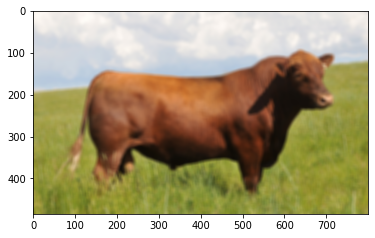

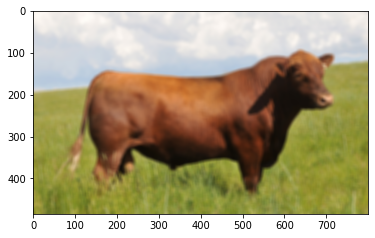

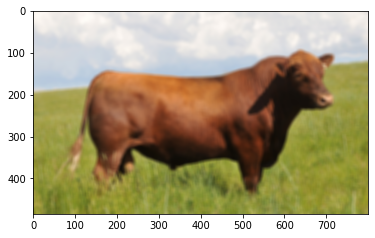

In [27]:
cow_model = semantic_segmentation()
segmentation_modeling(cow_model, cow_img_path, 10) # cow=10

소는 인식을 못하는군요. 다른 소 사진도 써보겠습니다.

(194, 260, 3)


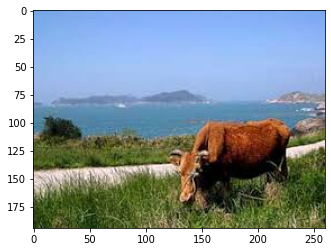

In [46]:
cow2_img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/cow2.jpg'
img_orig = cv2.imread(cow2_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(194, 260)


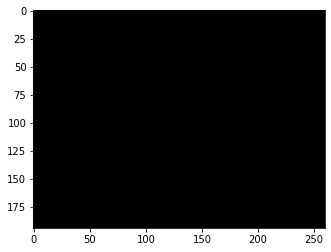

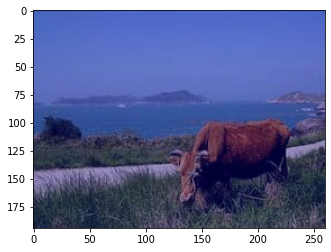

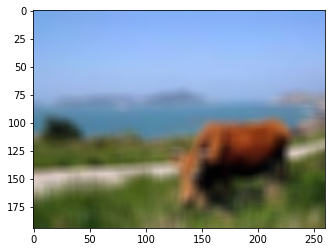

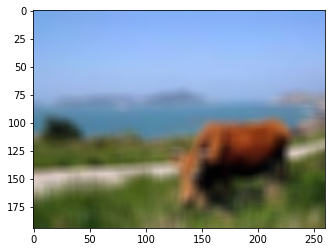

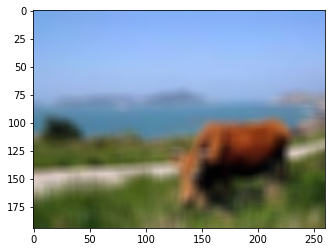

In [47]:
cow2_model = semantic_segmentation()
segmentation_modeling(cow2_model, cow2_img_path, 10) # cow=10

여전히 소를 인식하지 못합니다. 그럼 개는 괜찮을까요?

## **06. Dog Segmentation**

(1440, 1080, 3)


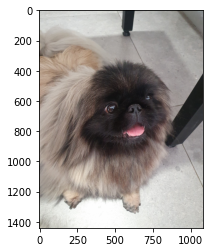

In [28]:
dog_img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/dog.jpeg'
img_orig = cv2.imread(dog_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1440, 1080)


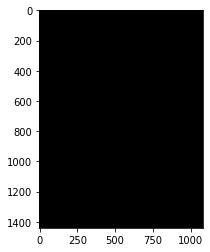

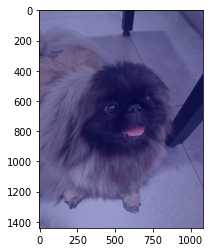

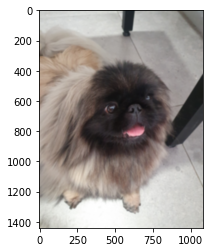

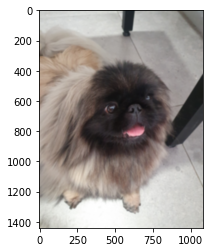

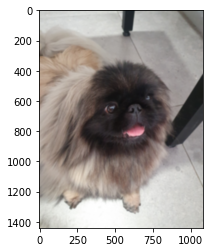

In [29]:
dog_model = semantic_segmentation()
segmentation_modeling(dog_model, dog_img_path, 12) # dog=12

특이하게 생긴 개라서 그런가 여전히 인식을 잘 못합니다.

더 '일반적으로' 생긴 개 사진을 써보겠습니다.

(832, 554, 3)


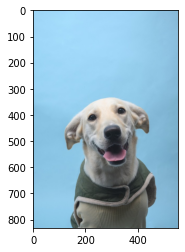

In [30]:
dog2_img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/dog2.jpeg'
img_orig = cv2.imread(dog2_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(832, 554)


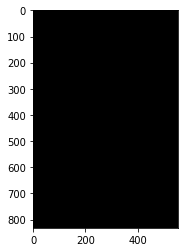

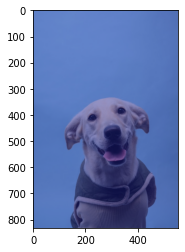

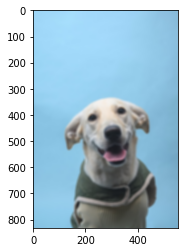

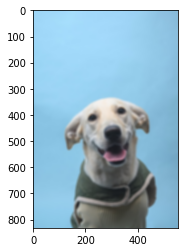

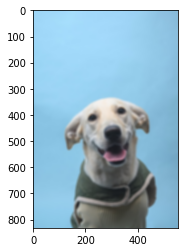

In [31]:
dog2_model = semantic_segmentation()
segmentation_modeling(dog2_model, dog2_img_path, 12) # dog=12

여전히 개를 인식을 못합니다. 왜지...?

## **06. 블러 & 크로마키 사진 제작**

- 홍성현님 깃허브 참고

In [35]:
def blur_machine(file, obj, back = None):
    # data
    img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/' + file  
    img_orig = cv2.imread(img_path) 

    # model
    model_dir = '/content/mydrive/MyDrive/AIFFEL/E10/model/'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    # 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)


    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    seg_color = tuple(colormap[LABEL_NAMES.index(obj)][::-1])

    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 값이 커질 수록 blurr의 강도가 심해진다.
    
    plt.subplot(121)
    plt.title('Befor Blur')
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    
    img_orig_blur = cv2.blur(img_orig, (13,13))
    plt.subplot(122)
    plt.title('After Blur')
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.subplot(121)
    plt.title('Extract')
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.subplot(122)
    plt.title('Compose')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # back이 있으면 
    if back:
        img_path = '/content/mydrive/MyDrive/AIFFEL/E10/data/' + back
        img_back = cv2.imread(img_path)
        img_resized = cv2.resize(img_orig, (img_back.shape[1], img_back.shape[0]))
        img_mask_resized = cv2.resize(img_mask_color, (img_back.shape[1], img_back.shape[0]))
        img_background_concat = np.where(img_mask_resized == 255, img_resized, img_back)
        plt.subplot(121)
        plt.title('Background')
        plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
        plt.show()
    
    
print('Done!')
        

Done!


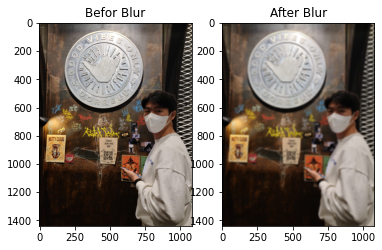

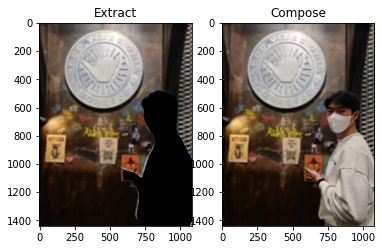

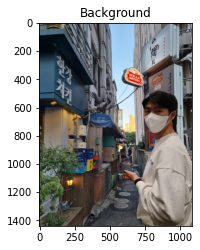

In [38]:
blur_machine('man.jpeg', 'person','bg.jpeg')

## **07. Problems**



### **7-1. 모델 인식 문제**

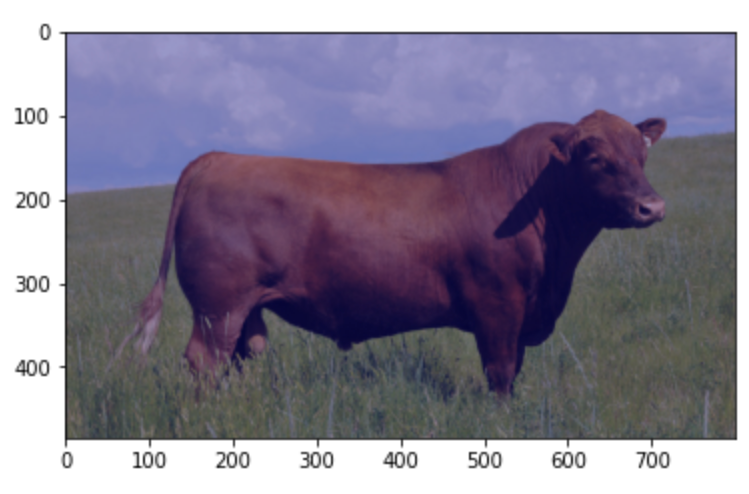

- 일단 cow1, cow2, dog1, dog2 모두 모델이 인식을 못합니다. DeepLab 모델 성능이 매우 좋다고 하던데 문제가 뭔지 모르겠네요.

- 모델을 바꿔봐야 할 것 같습니다.

> [링크](https://eda-ai-lab.tistory.com/549)를 보면 [PSPNET](https://arxiv.org/pdf/1612.01105.pdf)이 DeepLab보다 성능이 좋다고 합니다.
> - 링크 설명을 보면 기존 모델들은 global scene category clue를 잘 활용하지 못하는 문제가 있다고 합니다. 해당 이슈와 관련이 있을 지도 모르겠습니다.



### **7-2. 초점 문제**

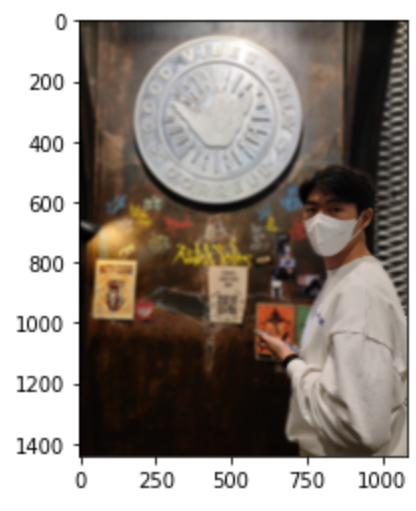

정상적으로 처리된 사진이고 원본 해상도도 높은 편이지만, 원본의 초점이 잘 맞지 않으면 블러 효과가 불명확합니다.

실제로도 어두운 곳이나 초점이 맞지 않는 상태에서 인물사진을 촬영하기가 매우 어려운데, 같은 원리가 아닐까 싶습니다.

# **회고**

- 많이들 CV가 NLP보다 쉽다던데 왜 저는 CV가 더 어려운지 잘 모르겠네요... 코딩실력문젠가?

- 프로젝트 진행 과정에서 LMS 오류때문에 좀 많이 버벅여서 힘들었습니다... 서터레수...

- colab으로 옮겼더니 버벅이는건 사라졌지만 pixellib이 애먹여서 고생을 했습니다. 모듈을 통해서 텐서플로우를 불러오던데 아마 버전이 워낙 빠르게 바뀌어서 내부 모듈에 적힌 경로상에 오류가 발생하는 것 같더라고요.

- 솔루션을 제시하는 부분이 특히 어려웠습니다. 실제 현실에서도 나타나는 문제도 있었고, 새로운 모델을 활용하려면 논문을 읽고 구현을 해봐야 하는데 아직 그만한 실력이 안된다는 점도 문제였습니다.
